In [9]:
import pandas as pd
import numpy as np

In [33]:
df = pd.read_csv(r"C:\Users\HP\Desktop\Projects\80_20 Classroom Participation\data\80_20 Classroom Participation Data.csv")

In [65]:
per_student = df.groupby("Student ID")["Total"].sum().reset_index().sort_values("Total", ascending=False)
per_student.head()


,Student ID,Total
59,S060,343.0
58,S059,183.0
61,S062,97.0
7,S008,55.0
9,S010,54.0


In [67]:
summary = per_student["Total"].describe()
print(summary)

count     62.000000
mean      17.822581
std       50.721200
min        0.000000
25%        0.000000
50%        1.000000
75%       11.750000
max      343.000000
Name: Total, dtype: float64


In [69]:
def pareto_metrics(values, top_p=0.20, target_share=0.80):
    v = values.sort_values(ascending=False).to_numpy()
    cum = np.cumsum(v)
    total = cum[-1]
    k = max(1, int(np.ceil(len(v) * top_p)))  # top 20% of students
    top_p_share = v[:k].sum() / total

    # % of students needed to reach 80% participation
    need_idx = np.searchsorted(cum, target_share * total, side="left")
    pct_students_for_target = (need_idx+1) / len(v)
    return top_p_share, pct_students_for_target

top20_share, pct_needed = pareto_metrics(per_student["Total"])
print("Share from top 20% students:", top20_share)
print("Percent of students needed for 80%:", pct_needed)


Share from top 20% students: 0.8959276018099548
Percent of students needed for 80%: 0.14516129032258066


In [71]:
subjects = ["Subject_1", "Subject_2", "Subject_3", "Subject_4"]

per_student_subjects = df.groupby("Student ID")[subjects].sum().reset_index()

# Pareto per subject
results = []
for subj in subjects:
    share, pct = pareto_metrics(per_student_subjects[subj])
    results.append({"Subject": subj, 
                    "Share from top 20%": share, 
                    "Pct students needed for 80%": pct})

pd.DataFrame(results)

,Subject,Share from top 20%,Pct students needed for 80%
0,Subject_1,0.893578,0.145161
1,Subject_2,0.954545,0.096774
2,Subject_3,0.934884,0.129032
3,Subject_4,0.989529,0.096774


In [73]:
df["Week"] = pd.to_datetime(df["Date"]).dt.to_period("W").astype(str)
weekly = df.groupby(["Week","Student ID"])["Total"].sum().reset_index()

rows = []
for wk, grp in weekly.groupby("Week"):
    share, pct = pareto_metrics(grp["Total"])
    rows.append({"Week": wk, 
                 "Share from top 20%": share, 
                 "Pct students needed for 80%": pct})
by_week = pd.DataFrame(rows).sort_values("Week")
by_week


,Week,Share from top 20%,Pct students needed for 80%
0,2025-09-01/2025-09-07,1.000000,0.112903
1,2025-09-08/2025-09-14,0.903101,0.145161
2,2025-09-15/2025-09-21,0.953917,0.129032
3,2025-09-22/2025-09-28,0.922156,0.129032
4,2025-09-29/2025-10-05,0.899628,0.145161


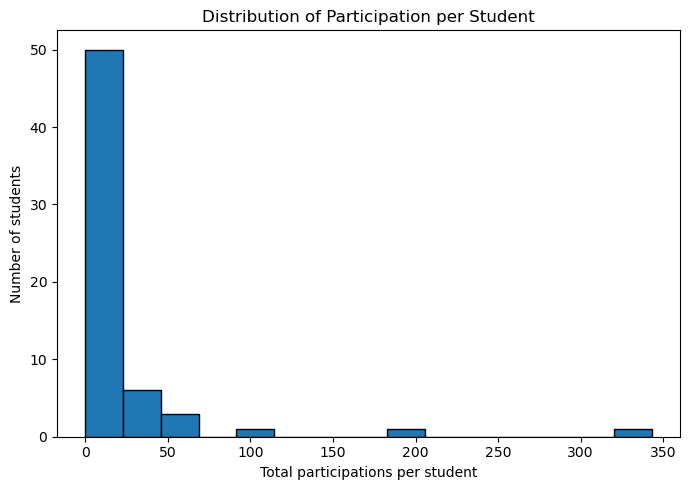

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.hist(per_student["Total"], bins=15, edgecolor="black")
plt.xlabel("Total participations per student")
plt.ylabel("Number of students")
plt.title("Distribution of Participation per Student")
plt.tight_layout()
plt.savefig("histogram_student_totals.png", dpi=300, bbox_inches="tight")
plt.show()

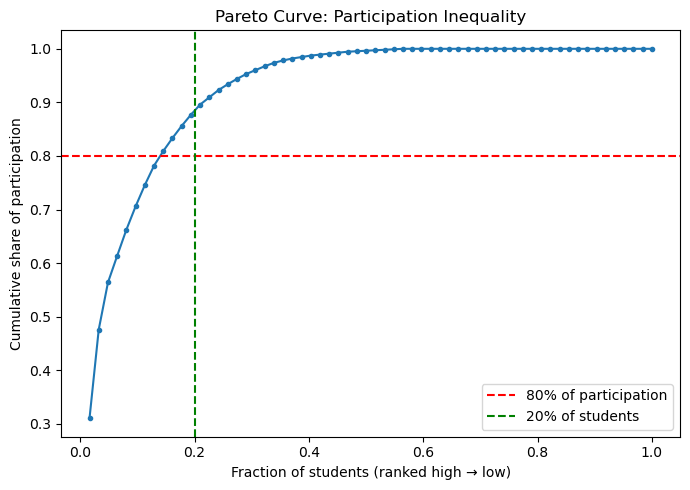

In [105]:
vals = per_student["Total"].sort_values(ascending=False).to_numpy()
cum = np.cumsum(vals) / vals.sum()
x = np.arange(1, len(vals)+1) / len(vals)

plt.figure(figsize=(7,5))
plt.plot(x, cum, marker=".")
plt.axhline(0.80, color="red", linestyle="--", label="80% of participation")
plt.axvline(0.20, color="green", linestyle="--", label="20% of students")
plt.xlabel("Fraction of students (ranked high → low)")
plt.ylabel("Cumulative share of participation")
plt.title("Pareto Curve: Participation Inequality")
plt.legend()
plt.tight_layout()
plt.savefig("pareto_curve.png", dpi=300, bbox_inches="tight")
plt.show()

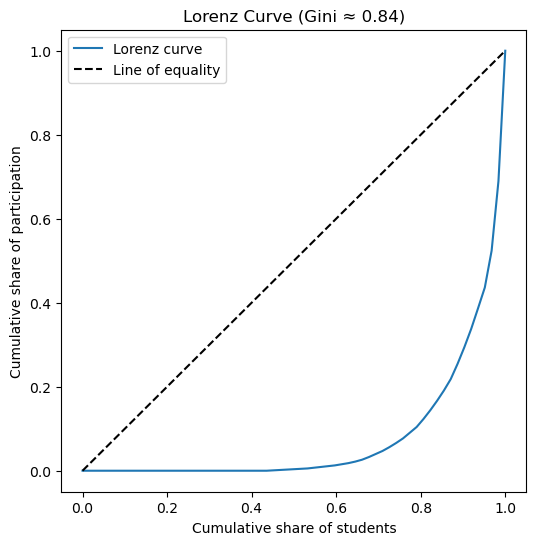

In [107]:
def lorenz_curve(values):
    v = np.sort(values.to_numpy())
    cum = np.cumsum(v)
    cum = np.insert(cum, 0, 0) / cum[-1]  # normalize
    x = np.linspace(0, 1, len(cum))
    return x, cum

def gini(values):
    v = np.sort(values.to_numpy())
    n = len(v)
    cum = np.cumsum(v)
    return (n+1 - 2*(cum.sum()/cum[-1]))/n if cum[-1] > 0 else 0

x, y = lorenz_curve(per_student["Total"])
g = gini(per_student["Total"])

plt.figure(figsize=(6,6))
plt.plot(x, y, label="Lorenz curve")
plt.plot([0,1],[0,1], color="black", linestyle="--", label="Line of equality")
plt.title(f"Lorenz Curve (Gini ≈ {g:.2f})")
plt.xlabel("Cumulative share of students")
plt.ylabel("Cumulative share of participation")
plt.legend()
plt.savefig("lorenz_curve.png", dpi=300, bbox_inches="tight")
plt.show()

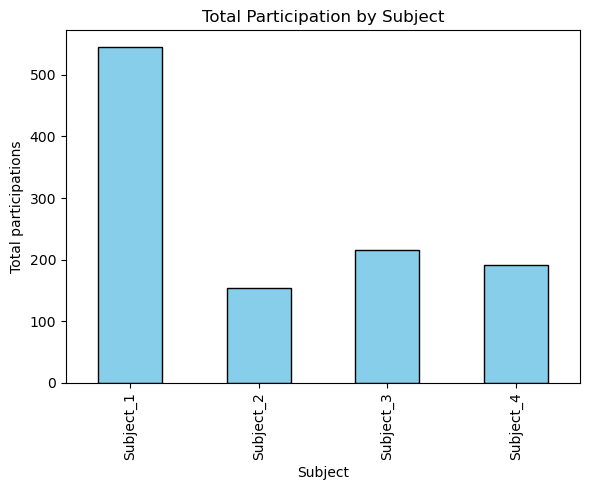

In [109]:
subjects = ["Subject_1","Subject_2","Subject_3","Subject_4"]
subject_totals = df[subjects].sum()

plt.figure(figsize=(6,5))
subject_totals.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Total Participation by Subject")
plt.ylabel("Total participations")
plt.xlabel("Subject")
plt.tight_layout()
plt.savefig("total_by_subject.png", dpi=300, bbox_inches="tight")
plt.show()